In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

scale = 0.75;
fsize = (12*scale, 9*scale)
mpl.rcParams['axes.titlesize'] = 26*scale
mpl.rcParams['legend.fontsize'] = 22*scale
mpl.rcParams['axes.labelsize'] = 20*scale
mpl.rcParams['lines.linewidth'] = 2*scale
mpl.rcParams['lines.markersize'] = 16*scale
mpl.rcParams['xtick.labelsize'] = 18*scale
mpl.rcParams['ytick.labelsize'] = 18*scale
    
def newton_sys(f, x0, tol, max_iter=50, show=False): #newton, modified so f must return f *and* jac
    x = np.array(x0)
    err = tol
    vals = [x]

    it = 0
    while err >= tol and it < max_iter:
        fx, jacx = f(x)
        delta = np.linalg.solve(jacx, fx)
        x = x - delta
        it += 1
        vals.append(x)
        err = np.max(np.abs(delta))
        # can replace with a relative error, delta/x
        if show:
            print(it,': {:.5f}, d= {:.2e}'.format(x[0],err))

    return x, it, np.array(vals)

def newton(f, x0, tol, max_iter=50, show=False): #newton, modified so f must return f *and* the deriv.
    x = x0

    it = 0
    delta = tol
    vals = [x]
    while abs(delta) >= tol and it < max_iter:
        fx, dfx = f(x)
        delta = -fx/dfx
        x = x + delta
        it += 1
        vals.append(x)
        if show:
            print(it,': {:.5f}, d= {:.2e}'.format(x,delta))

    return x, it, np.array(vals)

def rk4(func, interval, y0, nsteps): 
    ndim = len(y0)
    t = interval[0]
    b = interval[1]
    yvals = np.zeros([nsteps + 1, ndim])
    tvals = np.linspace(t, b, nsteps + 1)
    h = (b - t) / nsteps
    y = np.array(y0, dtype='float')  # y at current time, copying y0
    yvals[0, :] = y
    it = 0
    while t < b - 1e-9:
        f0 = func(t,y)
        f1 = func(t + 0.5*h, y + 0.5*h*f0)
        f2 = func(t + 0.5*h, y + 0.5*h*f1)
        f3 = func(t + h, y + h*f2)
        y += (h/6)*(f0 + 2*f1 + 2*f2 + f3)
        it += 1
        t += h
        yvals[it, :] = y
        tvals[it] = t

    return [tvals, yvals]


def rkf(func, interval, y0, hmin=1e-6, hmax=1, atol=1e-4, rtol=1e-4):

    coeffs = [[0] * 6 for i in range(6)]  # could be defined in a global

    # For coeffs[j]:
    # First entry: c_j, then a_{j,1} through a_{j,j-1}
    coeffs[1][0:2] = [1 / 4, 1 / 4]  # f2
    coeffs[2][0:3] = [3 / 8, 3 / 32, 9 / 32]  # f3
    coeffs[3][0:4] = [12 / 13, 1932 / 2197, -7200 / 2197, 7296 / 2197]
    coeffs[4][0:5] = [1, 439 / 216, -8, 3680 / 513, -845 / 4104]
    coeffs[5][0:6] = [1 / 2, -8 / 27, 2, -3544 / 2565, 1859 / 4104, -11 / 40]

    # weights for f1, f2, ... f6
    w4 = [25 / 216, 0, 1408 / 2565, 2197 / 4104, -1 / 5, 0]  # fourth order weights
    w5 = [16 / 135, 0, 6656 / 12825, 28561 / 56430, -9 / 50, 2 / 55]  # fifth order weights

    T = [interval[0]]
    u = np.array(y0, dtype='float') 
    Y = [list(y0)]
    t = interval[0]
    it = 0
    fvals = [np.zeros(6)] * 6
    utmp = np.zeros_like(u)
    h = hmin  # start with the minimum h
    safety = 0.8

    while t < interval[1] - 1e-12:
        fvals[0] = func(t, u)
        for k in range(1, 6):
            utmp[:] = u[:]
            for m in range(1, k + 1):
                utmp += h * coeffs[k][m] * fvals[m - 1]
            fvals[k] = func(t + h * coeffs[k][0], utmp)

        utmp[:] = u[:]
        for k in range(6):
            utmp += h * w5[k] * fvals[k]
            u += h * w4[k] * fvals[k]

        t += h
        it += 1
        Y.append(list(u))
        T.append(t)

        # error estimation
        err = max(abs(u - utmp))
        if err > 0:
            h = safety * h * (min(atol, rtol*np.max(np.abs(u)))/ err) ** (1 / 5)
            h = max(h, hmin)
            h = min(h, hmax)

    return np.array(T), np.array(Y)

### Two-point boundary value problem (example)

Consider the two-point BVP (in $[1,2]$),

$$y'' = 2y^3 - 6y - 2x^3, \quad y(1) = 2, \quad y(2) = 5/2$$

which has the exact solution

$$y(x) = x + 1/x.$$

We solve this using shooting: solve the initial value problem

$$y'' = 2y^3 - 6y - 2x^3, \quad y(1) = 2, \,\, y'(1) = s$$

for $y(x;s)$ and finding a zero of the goal function $G(s) = y(2;s) - 5/2.$

Note that due to the non-linear $y^3$ term, the IVP may blow up for some values of $y'(1)$ inside the interval $[1,2]$. This occurs for $y'(1) > 1/2$ (possibly for others), so one should be careful when choosing an initial guess for $s$.

1 : 0.08949, d= -1.11e-01
2 : 0.01768, d= -7.18e-02
3 : 0.00068, d= -1.70e-02
4 : 0.00000, d= -6.82e-04
5 : 0.00000, d= -1.02e-06
6 : -0.00000, d= -2.26e-12
s =  -3.9045508517083905e-14    # of iterations:  6


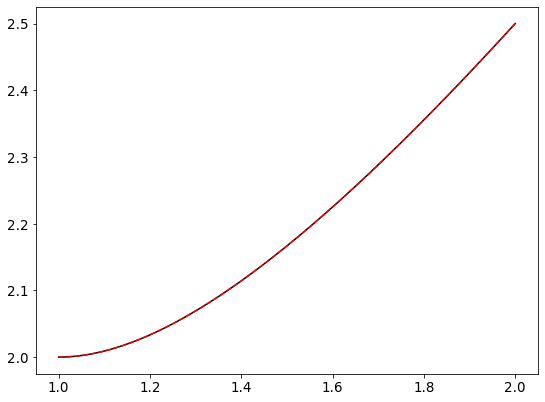

In [2]:
y_at_a = 2
y_at_b = 5/2

def exact(t):
    return t + 1/t

def odef(t,y):
    return np.array([y[1], 2*y[0]**3 - 6*y[0] - 2*t**3])

def odef_plus(t,y): #y[0] = y, y[1] = y', y[2] = z, y[3] = z'
    return np.array([y[1], 2*y[0]**3 - 6*y[0] - 2*t**3, 
                     y[3], (6*y[0]**2 - 6)*y[2]])

def goal(s, nsteps=2000): #goal function for this example, plus goal deriv. for newton
    yz0 = np.array([y_at_a, s, 0, 1]) 
    t,yz = rk4(lambda t,y: odef_plus(t, y), [1,2], yz0, nsteps)
    
    return yz[-1,0] - y_at_b, yz[-1,2] #G(s) and G'(s)

s0 = 0.2 #(exact solution for BVP: s = 0)
nsteps = 2000
s, it, vals = newton(lambda s: goal(s, nsteps), s0, 1e-8, show=True)
print('s = ', s, '   # of iterations: ', it)
T, Y = rk4(odef, [1, 2], [y_at_a, s], nsteps)
plt.figure(figsize=fsize)
plt.plot(T, Y[:,0],'-k', T, exact(T),'--r');

### Infinite boundary conditions (the cheap way)

Example: Blasius Boundary layer solution using shooting. Equation for $f(x)$:

$$ f''' + \frac{1}{2}f''f = 0, \quad f(0) = f'(0) = 0, \qquad \lim_{x\to\infty} f'(x) = 1.$$

Let $y_1 = f, \, y_2 = f', \, y_3 = f''$. Then the shooting problem is:

$$ \begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix}' =  \begin{bmatrix} y_2 \\ y_3 \\ -y_1y_3/2 \end{bmatrix}, \qquad \vec{y}(0) =  \begin{bmatrix} 0 \\ 0 \\ s \end{bmatrix}$$

(the shooting guess is for $s = y''(0)$). We solve the IVP on a large interval $[0,L]$ and use the goal
$$G(s) = y_2(L;s) - 1.$$
Note that the use of a finite length is a crude approximation. 

For Newton, let $z = dy/ds = $; then it solves the IVP

$$z''' + \frac{1}{2}(y_1z'' + y_3z) = 0, \quad z(0) = z'(0) = 0, \,\, z''(0) = 1.$$

which is then converted to a first order system with $z_2 = z'$ and $z_3 = z''.$ In total, we solve for $(y_1,y_2,y_3,z_1,z_2,z_3)$ at each step in shooting.

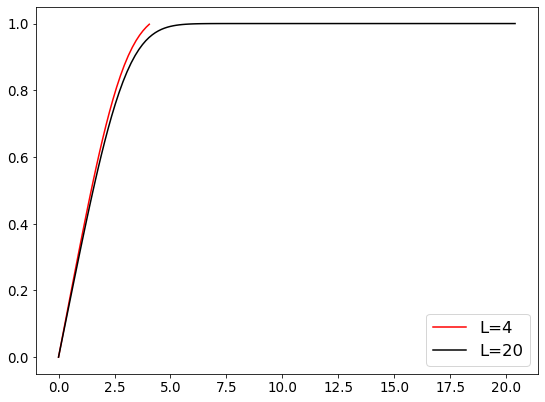

In [3]:
def bla(t,y):
    return np.array([y[1], y[2], -0.5*y[0]*y[2]])

def bla_plus(t,y):
    dy = np.zeros(6)
    dy[0:3] = [y[1], y[2], -0.5*y[0]*y[2]] #(y,y',y'')
    dy[3:6] = [y[4], y[5], -0.5*(y[0]*y[5] + y[2]*y[3])] #(z,z',z'')
    return dy

def goal(s, L, tol=1e-6): 
    yz0 = np.array([0, 0, s, 0, 0, 1]) 
    t,yz = rkf(bla_plus, [0, L], yz0, atol=tol*L, rtol=tol)
    g = yz[-1,1] - 1
    gp = yz[-1,4]
    return g, gp

s0 = 0.5
tol = 1e-8
L1 = 4
L2 = 20
s, it, vals = newton(lambda s: goal(s, L1, tol), s0, 1e-8, show=False)
s2, it2, vals2 = newton(lambda s: goal(s, L2, tol), s0, 1e-8, show=False)
T, Y = rkf(bla, [0, L1], [0, 0, s], atol=tol*L1, rtol=tol)
T2, Y2 = rkf(bla, [0, L2], [0, 0, s2], atol=tol*L2, rtol=tol)
plt.figure(figsize=fsize)
plt.plot(T,Y[:,1],'-r')
plt.plot(T2,Y2[:,1],'-k')
plt.legend({'L=4','L=20'});


### Shooting (when the initial guess is hard)

Troesch's problem (source: https://doi.org/10.1016/0021-9991(73)90165-4) is

$$y'' = \mu \sinh(\mu y), \quad y(0) = 0, \quad y(1) = 1$$

which arises in plasma physics. The variational ODE for $z = dy/ds$ (with $y'(0) = s$) is

$$ z'' = -\mu^2 \cosh(\mu y) z, \quad z(0) = 0, \quad z'(0) = 1$$ 

Here, they are solved together; for more complicated ODEs,
a faster implementation would solve for y first, then solve for z *one the same grid*.
This way, the fact that the $z$-ODE is linear can be exploited.

Note that the ODE can be ill-behaved; it has singularities in $[0,1]$ for certain values of $\mu$. In particular, it can be shown that if $y'(0) > 8e^{-\mu}$ then the singularity is inside $[0,1]$. Shooting guesses must avoid this case!

For example, when $\mu = 5$ (with $y'(0) \approx 0.0457$), the guess for $s$ must be close to $y'(0)$ - about $s\approx 0.03-0.05$ to work. With $s = 0$ or $s= 0.06$, eeither the initial or first step causes divergence.
    

1 : 0.04718, d= 7.18e-03
2 : 0.04587, d= -1.30e-03
3 : 0.04575, d= -1.22e-04
4 : 0.04575, d= -8.55e-07
5 : 0.04575, d= -4.10e-11
s =  0.045750461411100785    # of iterations:  5


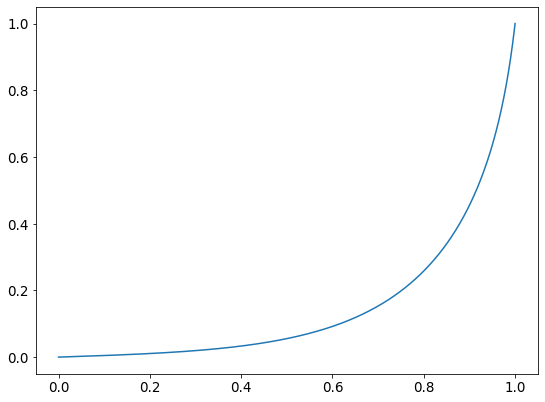

In [4]:
mu = 5

def odef(t,y):
    return np.array([y[1], mu*np.sinh(mu*y[0])])

def odef_plus(t,y): #y[0] = y, y[1] = y', y[2] = z, y[3] = z'
    return np.array([y[1], mu*np.sinh(mu*y[0]), y[3], mu**2*np.cosh(mu*y[0])*y[2]])

def goal(s, nsteps=2000): #goal function for this example, plus goal deriv for use with newton
    yz0 = np.array([0, s, 0, 1]) 
    t,yz = rk4(lambda t,y: odef_plus(t, y), [0,1], yz0, nsteps)
    
    return yz[-1,0] - 1, yz[-1,2]

s0 = 0.04
#s0 = 2*8*np.exp(-mu) #bad starting value
nsteps = 2000
s, it, vals = newton(lambda s: goal(s, nsteps), s0, 1e-8, show=True)
#s, it, vals = bisect(lambda s: goal(s, nsteps)[0], 0, 1, 1e-8, show=True)
print('s = ', s, '   # of iterations: ', it)
T, Y = rk4(odef, [0, 1], [0, s], nsteps)
plt.figure(figsize=fsize)
plt.plot(T, Y[:,0])

### Period finding

The Van der Pol equation is

$$y'' + \mu(y^2-1)y' + y = 0.$$

The system (depending on $\mu$) may have a unique periodic solution (a `limit cycle'). 

When this solution is stable, we could find it by picking a nearby starting value and letting it converge. However, this technique does not work if the limit cycle is unstable, and it requires knowing how fast it is converging etc.

A more direct approach is to solve for the solution directly, writing it is a boundary value problem:

$$y'' + \mu(y^2-1)y' + y = 0, \quad y(0) = y(T), \quad y'(0) = y'(T)$$

where $T$ is the period (to be found). We also fix the `starting point' for the cycle by imposing
$$y(0) = c$$

First, this can be written as a first order system for $x = (x_1,x_2)$ of the form

$$x' = F(x), \quad x(0) = x(T).$$ 

Byssetting $\tau = t/T$ and considering $x(\tau)$ instead, we can scale $T$ out of the BCs to get

$$\frac{dx}{d\tau} = TF(x), \quad x(0) = x(1).$$

This can be considered to be an ODE system for $(x_1,x_2,T)$ with the addition of the ODE $T' = 0$. In full,

$$\frac{dx}{d\tau} = TF(x), \,\, T'=0, \quad x_1(0) = x_1(1), \, x_2(0) = x_2(1),  \,\, x_1(0) = c$$

is the boundary value problem to be solved in `standard' form (as a first order system).

For using Newton's method, some simplfiication is allowed due to the trivial $T' = 0$ equation. TO apply shooting, we solve the initial value problem

$$\frac{dx}{d\tau} = TF(x), \quad x_1(0) = c, \,\, x_2(0) = s$$

where the `guess' $(s,T)$ is now two-dimensional. The goal function is
$$g(s,T) = (x_1(1;s) - c, x_2(1;s) - s).$$
The Jacobian of $g$ needed for newton's method requires computing the variations
$$ z = dx/ds, \quad w = dx/dT$$
(derivation left as an exercise).

1 : 1.94909, d= 1.09e+00
2 : 4.29626, d= 2.35e+00
3 : 2.37319, d= 1.92e+00
4 : 2.37117, d= 8.04e-03
5 : 2.37109, d= 8.12e-05
6 : 2.37109, d= 3.73e-09
period: 7.096374


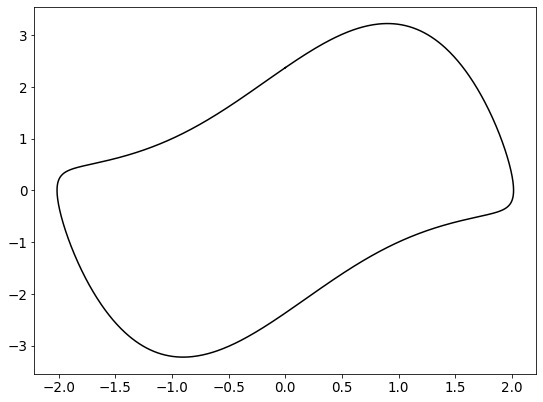

In [5]:
mu = 1.5
y_at_0 = 0
def vdp(t,y):
    return np.array([y[1], -y[0] + mu*(1-y[0]**2)*y[1]])

def vdp_jac(t,y):
    return np.array([ [0, 1], [ -2*mu*y[0]*y[1] - 1, mu*(1-y[0]**2)] ])

def vdp_plus(t,y, per): #vdp ODE, plus variations
    f = vdp(t,y[0:2])
    jac = vdp_jac(t,y[0:2])
    dy = np.zeros(6)
    dy[0:2] = per*f #y'
    dy[2:4] = per*np.dot(jac,y[2:4]) #(dy/ds)'
    dy[4:6] = f + per*np.dot(jac,y[4:6]) #(dy/dT)'
    return dy

def goal(s, nsteps=2000): 
    yz0 = np.array([y_at_0, s[0], 0, 1, 0, 0]) 
    t,yz = rk4(lambda t,y: vdp_plus(t, y, s[1]), [0,1], yz0, nsteps)

    g = np.array([yz[-1,0] - y_at_0, yz[-1,1] - s[0]])
    gjac = np.array([ [yz[-1,2], yz[-1,4]], [yz[-1,3]-1, yz[-1,5]] ])
    return g, gjac

s0 = [2, 2*np.pi] # works for 1.5, not for 1.8 (converges slow to a multi-period)
nsteps = 2000
s, it, vals = newton_sys(lambda s: goal(s, nsteps), s0, 1e-8, show=True)
T, Y = rk4(vdp, [y_at_0, s[1]], [0, s[0]], nsteps)
print('period: {:.6f}'.format(s[1]))

plt.figure(figsize=fsize)
plt.plot(Y[:,0], Y[:,1],'-k')